
# Predicting the Red Wine quality score 

**Introduction**

A 2022 study conducted by John Dunham and Associates found that the wine industry accounts for $276.07 billion economic output in America. While wine is a cornerstone of the US economy, few individuals are actually experts in the subject, with only 269 Master Sommeliers in the world. There is a clear disconnect between the economic impact of wine, and the number of individuals trained to assess a wine's quality, leaving room for restaraunts, liquor stores, and wineries to over (or under) price wines for consumers. During our project, we will be using predictors that could be found by contacting wine producers to see if we can predict the quality [0-10] of a red wine using regression.

The dataset chosen was collected by Cortez et al.(2009) for their paper, "Modeling wine preferences by data mining from physicochemical properties", in which they modelled wine preference on a scale of 0 [bad] to 10 [excellent]. Cortez et al. used 12 types of physicochemical properties, whereas we we will use 7 in our prediction model.  


**Preliminary Exploratory Data Analysis:**



In [1]:
#loading necessary packages
set.seed(4789)
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
library(GGally)
library(cowplot)
library(broom)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data <- read_delim(url, skip = 1, delim = ";",
                       col_names = c("fixed_acidity",
                                     "volatile_acidity",
                                     "citric_acid",
                                     "residual_sugar",
                                     "chlorides",
                                     "free_sulfur_dioxide",
                                     "total_sulfur_dioxide",
                                     "density",
                                     "pH",
                                     "sulphates",
                                     "alcohol",
                                     "quality")) |>
              mutate(across("fixed_acidity":"quality", as.numeric))
wine_data

#reading wine_data

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


Table 1. Table of Quantitative Wine Qualities from Wine_Data. 

We see a large range of data in Table 1. For instance, Fixed Acidity compared to Citric_Acid have very different scales. Scaling this data would be beneficial when performing preprocessing for KNN Regression, to ensure that certain predictors do not influence our model more on the basis of their scale only. 

In [3]:
#splitting wine data into training/testing
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)



In [4]:
#summary of wine data

wine_max <- wine_training |>
            summarize(across("fixed_acidity":"quality", max, na.rm = TRUE))

wine_min <- wine_training |>
            summarize(across("fixed_acidity":"quality", min, na.rm = TRUE))

wine_mean <- wine_training |>
             summarize(across("fixed_acidity":"quality", mean, na.rm = TRUE))

wine_summary <- bind_rows(wine_min, wine_mean, wine_max)
wine_summary

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.600000,0.1200000,0.0000000,0.90000,0.01200000,1.00000,6.00000,0.9900700,2.740000,0.3300000,8.40000,3.000000
8.274875,0.5292571,0.2673122,2.50505,0.08690317,16.10601,47.34349,0.9967086,3.316135,0.6554174,10.43147,5.634391
15.900000,1.3300000,1.0000000,15.50000,0.61000000,72.00000,289.00000,1.0032000,4.010000,2.0000000,14.90000,8.000000


Table 2. The above table is a summary of the training dataset. 

The first row is the minimum value of each variable, the second row is the mean value of each variable, and the third row is the maximum value of each variable. This lets us know the range of values we should expect to see for each variable when we do our analysis.

In [5]:
# making a correlation plot
corr <- cor(wine_training)
colnames(corr)<- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide", "Total Sulfur Dioxide","Density", "pH", "Sulphates", "Alcohol", "Quality") 
rownames(corr)<- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide", "Total Sulfur Dioxide","Density", "pH", "Sulphates", "Alcohol", "Quality") 
round(corr, 2)


,Fixed Acidity,Volatile Acidity,Citric Acid,Residual Sugar,Chlorides,Free Sulfur Dioxide,Total Sulfur Dioxide,Density,pH,Sulphates,Alcohol,Quality
Fixed Acidity,1.00,-0.25,0.66,0.07,0.11,-0.17,-0.11,0.66,-0.68,0.18,-0.09,0.10
Volatile Acidity,-0.25,1.00,-0.55,0.00,0.05,-0.01,0.08,0.04,0.23,-0.25,-0.19,-0.37
Citric Acid,0.66,-0.55,1.00,0.12,0.20,-0.06,0.05,0.35,-0.54,0.29,0.08,0.19
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sulphates,0.18,-0.25,0.29,-0.03,0.38,0.04,0.04,0.14,-0.19,1.00,0.09,0.24
Alcohol,-0.09,-0.19,0.08,0.05,-0.23,-0.06,-0.21,-0.52,0.22,0.09,1.00,0.47
Quality,0.10,-0.37,0.19,-0.02,-0.15,-0.05,-0.19,-0.20,-0.02,0.24,0.47,1.00


Table 3. Correlation Values between Wine_Training objects.

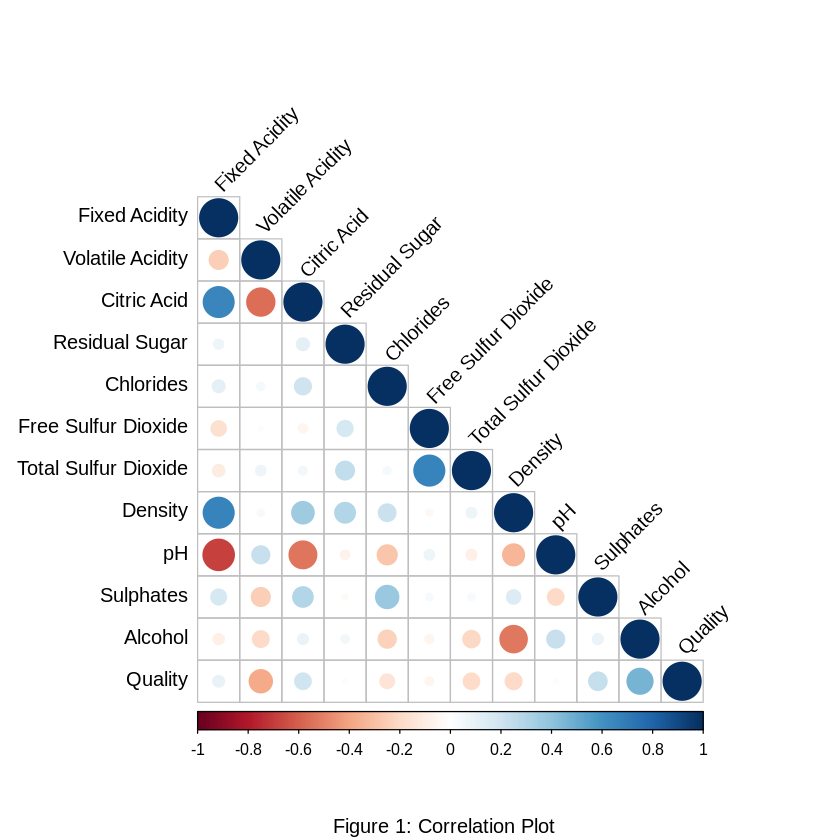

In [6]:
corrplot(corr, type = "lower", 
         tl.col = "black", tl.srt = 45) 
title(sub = list("Figure 1: Correlation Plot", font= 20)) 

 Figure 1. Correlation Plot (made using Table 3), with dark red and dark blue being high correlation and white being low correlation. Alcohol, Total Sulfur Dioxide, Volatile Acidity, Citric Acid, Density, and Sulphates are notably correlated to wine quality. 

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


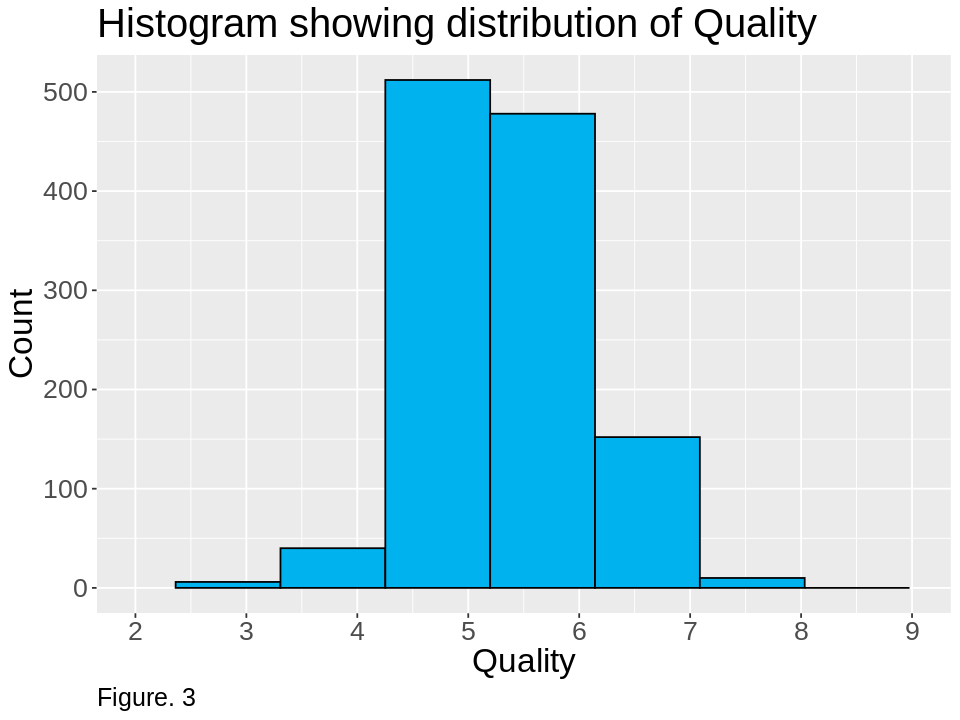

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)
 wine_training |> 
                ggplot(aes(x = quality))+ geom_histogram(binwidth = 0.945, fill = "deepskyblue2", col = "black") +
                        theme(text = element_text(size = 20),
                        plot.caption = element_text(size = 15, hjust = 0)) + labs(x = "Quality", 
                         y= "Count", title = "Histogram showing distribution of Quality", caption = "Figure. 3") +
                          scale_x_continuous(breaks = c(2,3,4,5,6,7,8,9), lim = c(2,9))


Figure 3. A histogram showing the distribution of the training dataset. 

We notice an imbalance in our data, with most values centred around the quality of 5 to 7. This imbalance would affect our data analysis, so we expect our model to predict best around 5 to 7. {48 words}

**Methods**

Building a good model requires a careful selection of relevant predictors. Our dataset contains 11 variables of which many are redundant. We will use both our insights and a correlation matrix to determine which ones to use.

Firstly, alcohol will be used, since it is known to impact individuals' perception of wine flavour, thus influencing perceived quality (Caballero & Segura, 2017). Secondly, total sulphur dioxide will be used, total sulphur dioxide acts as an antioxidant with probable impacts on quality (Araptisas et al., 2018). The correlation matrix also suggests that sulphates, volatile_acidity, citric_acid and density are significant. The ID is distributed randomly so it does not have an impact.

Even though our prediction set consists of 11 integer values, we will be using regression for prediction. The quality values are ordered and the dataset is too unbalanced, with most of the values centred around the mean value, to use a classifier. We believe using multiple linear regression with 6 regressors should provide us with the best results. Rounding our predicted number to the nearest integer will give us a quality score that could be easily checked by the confusion matrix. We will then use the values to calculate the accuracy score.

We will build and compare k-nn and linear regression models to know which model better suits our data.{17 words}

**K-nn Regression**

First, we make a k-nn model to find our regression model's ideal number of neighbours. We build our recipe with training data and center and scale all the predictors. Then, we perform a 10-fold cross-validation and test the number of neighbours from 1 to 150. Finally, we add the recipe and the model to a workflow and get a tibble showing RMSE values for different neighbours.{66 words}

In [8]:
# MAKING A K-NN REGRESSION MODEL.
wine_spec_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 
# MAKING THE K-NN RECIPE.
wine_recipe_knn <- recipe(quality ~ alcohol+ total_sulfur_dioxide + 
                          volatile_acidity + citric_acid + density + sulphates , data = wine_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())
# PERFORMING CROSS-VALIDATION.
wine_vfold <- vfold_cv(wine_training, v = 10, strata = quality)
gridvals <- tibble(neighbors = seq(1, 150)) 
wine_results_knn <- workflow() |> 
                    add_recipe(wine_recipe_knn) |> 
                    add_model(wine_spec_knn) |>
                    tune_grid(resamples = wine_vfold, grid = gridvals) |> 
                    collect_metrics() |>
                    filter(.metric == "rmse")


In [9]:
wine_results_knn

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.7864897,10,0.014339136,Preprocessor1_Model001
2,rmse,standard,0.7053903,10,0.010732739,Preprocessor1_Model002
3,rmse,standard,0.6823865,10,0.008287051,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
148,rmse,standard,0.6612931,10,0.01177890,Preprocessor1_Model148
149,rmse,standard,0.6614031,10,0.01181208,Preprocessor1_Model149
150,rmse,standard,0.6614471,10,0.01183242,Preprocessor1_Model150


Table 4. RMSE Results following 10 Fold Cross Validation in KNN Regression

We arrange the RMSEs in ascending order and extract the number of neighbours for which the RMSE is lowest.{19 words}

In [10]:
# GETTING K FOR WHICH THE RMSE IS LOWEST.
wine_knn_min <- wine_results_knn |> 
                arrange(mean) |> 
                head(1) |>
                pull(neighbors)
wine_knn_min
# PLOTTING RMSE VS NEIGHBOURS TO VISUALISE WHERE RMSE IS LOWEST.
options(repr.plot.width = 10, repr.plot.height = 8)
wine_k_plot <- wine_results_knn |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 1) +
    geom_line(size = 1) +
    geom_vline(xintercept = 15, colour = "red", size = 1) +
    labs(x = "Neighbours (K)",
         y = "RMSE",
         title = "RMSE vs Neighbours ", captions = "Figure. 2") +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0)) + 
        scale_x_continuous(breaks = c(0,15,30,45,60,75,90), lim= c(0,90))        

[1] 15

Warning message:
“Removed 60 rows containing missing values (geom_point).”
Warning message:
“Removed 60 row(s) containing missing values (geom_path).”


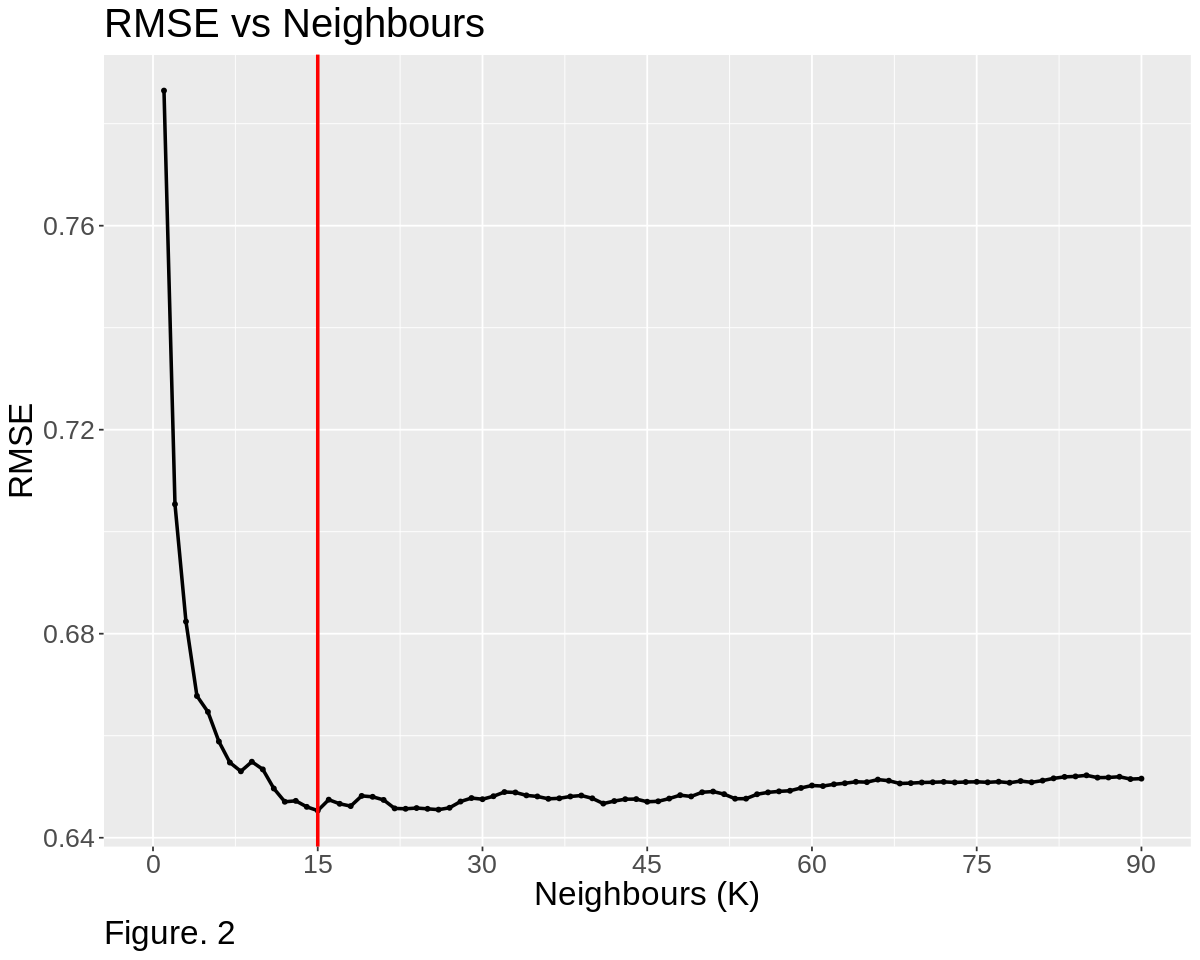

In [11]:
wine_k_plot

Figure 2. shows the RMSE (Root mean square error) vs neighbours plot. This plot helps us to visualize how RMSE varies with neighbours. The plot shows that RMSPE is lowest when the neighbours are 15. As a result, we choose k = 15 for the k-nn model. {48 words}

Now we will make a new k-nn regression model with the best k value (k = 15).

 Finally, we add the new model to a workflow, fit the model with the training dataset, predict the testing data set, and extract the RMSPE(Root mean square prediction error) of the k-nn regression model.{51words}

In [12]:
# MAKING THE K-NN MODEL WITH IDEAL NUMBER OF NEIGHBOURS.
wine_best_spec_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_knn_min) |>
          set_engine("kknn") |>
          set_mode("regression")
# FITTING THE MODEL WITH THE TRAINING DATA.
wine_best_fit_knn <- workflow() |>
           add_recipe(wine_recipe_knn) |>
           add_model(wine_best_spec_knn) |>
           fit(data = wine_training)
# PREDICTING THE MODEL ON TESTING DATA.
wine_summary_knn <- wine_best_fit_knn |>
           predict(wine_testing) |>
           bind_cols(wine_testing) |>
           metrics(truth = quality, estimate = .pred)

wine_summary_knn
# GETTING THE RMSPE FROM K-NN REGRESSION.
wine_knn_rmse <- wine_summary_knn |> 
                    filter(.metric == 'rmse') |> 
                    pull()
wine_knn_rmse

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6671486
rsq,standard,0.3735247
mae,standard,0.5160432


[1] 0.6671486

Table 5. Tibble containing RMSPE of KNN Regression Model from Testing Data

We get a RMSPE of 0.667148620470365. We will now make a linear model to compare the errors in both the model.{21 words}

**Linear Regression**

In [13]:
lm_spec <- linear_reg() |>
           set_engine("lm") |>
           set_mode("regression")

lm_recipe <- recipe(quality ~ alcohol + total_sulfur_dioxide + 
                    volatile_acidity + citric_acid + density + sulphates, data = wine_training)

lm_fit <- workflow() |>
       add_recipe(lm_recipe) |>
       add_model(lm_spec) |>
       fit(wine_training)


lm_fit

lm_rmspe <- lm_fit |>
         predict(wine_testing) |>
         bind_cols(wine_testing) |>
         metrics(truth = quality, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)               alcohol  total_sulfur_dioxide  
            -5.28804               0.29671              -0.00216  
    volatile_acidity           citric_acid               density  
            -1.23185              -0.15553               8.18693  
           sulphates  
             0.70654  


[1] 0.6632904

In [14]:

lm_model<- lm(quality ~ alcohol + total_sulfur_dioxide + 
                    volatile_acidity + citric_acid + density + sulphates, data = wine_testing)
lm_residuals_augment<- augment(lm_model)
lm_residuals_augment_rounded <- lm_residuals_augment |>
                                    round() |>
                                    select(.fitted) |>
                                    bind_cols(lm_residuals_augment) |>
                                    rename(.fitted_rounded = .fitted...1, .fitted = .fitted...9) |>
                                    select(quality,alcohol,total_sulfur_dioxide,volatile_acidity,citric_acid,density,sulphates,.fitted,
                                          .fitted_rounded, .resid,.hat, .sigma, .cooksd, .std.resid)

lm_residuals_augment_rounded

New names:
• `.fitted` -> `.fitted...1`
• `.fitted` -> `.fitted...9`


quality,alcohol,total_sulfur_dioxide,volatile_acidity,citric_acid,density,sulphates,.fitted,.fitted_rounded,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,9.8,54,0.76,0.04,0.9970,0.65,5.089126,5,-0.08912615,0.008610935,0.6665653,2.243224e-05,-0.13445664
6,9.8,60,0.28,0.56,0.9980,0.58,5.706694,6,0.29330582,0.014616847,0.6664139,4.174314e-04,0.44383065
5,9.4,34,0.70,0.00,0.9978,0.56,5.024634,5,-0.02463448,0.011118792,0.6665794,2.224111e-06,-0.03721092
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,11.9,26,0.350,0.33,0.99470,0.60,6.321229,6,-0.3212293,0.010669852,0.6663815,0.0003625823,-0.4851139
6,9.5,38,0.620,0.08,0.99651,0.82,5.327213,5,0.6727867,0.011237750,0.6657063,0.0016770682,1.0163204
5,10.2,44,0.645,0.12,0.99547,0.71,5.421489,5,-0.4214892,0.006346753,0.6662393,0.0003680910,-0.6351382


Table 6. A Table Containing Residual Values, Testing Set Predictor Values, and Wine Quality

In [15]:
# PLOTTING A RESIDUAL PLOT TO VISUALISE THE DISTRIBUTION OF RESIDUALS WITH RESPECT TO QUALITY.
options(repr.plot.width = 12.5, repr.plot.height = 10)
lm_residual_plot_testing<-ggplot(lm_residuals_augment_rounded, aes(x =quality, y = .resid )) + 
                    geom_point(alpha = 0.35,  position = "jitter") +geom_hline(yintercept= 0)+
                labs(x = "Quality", y= "Residuals", title = "Residuals vs. Quality", caption = "Figure 6.")+
                    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 30, hjust = 0))+ 
                scale_x_continuous(breaks = c(2,3,4,5,6,7,8), lim = c(3,8))


Warning message:
“Removed 4 rows containing missing values (geom_point).”


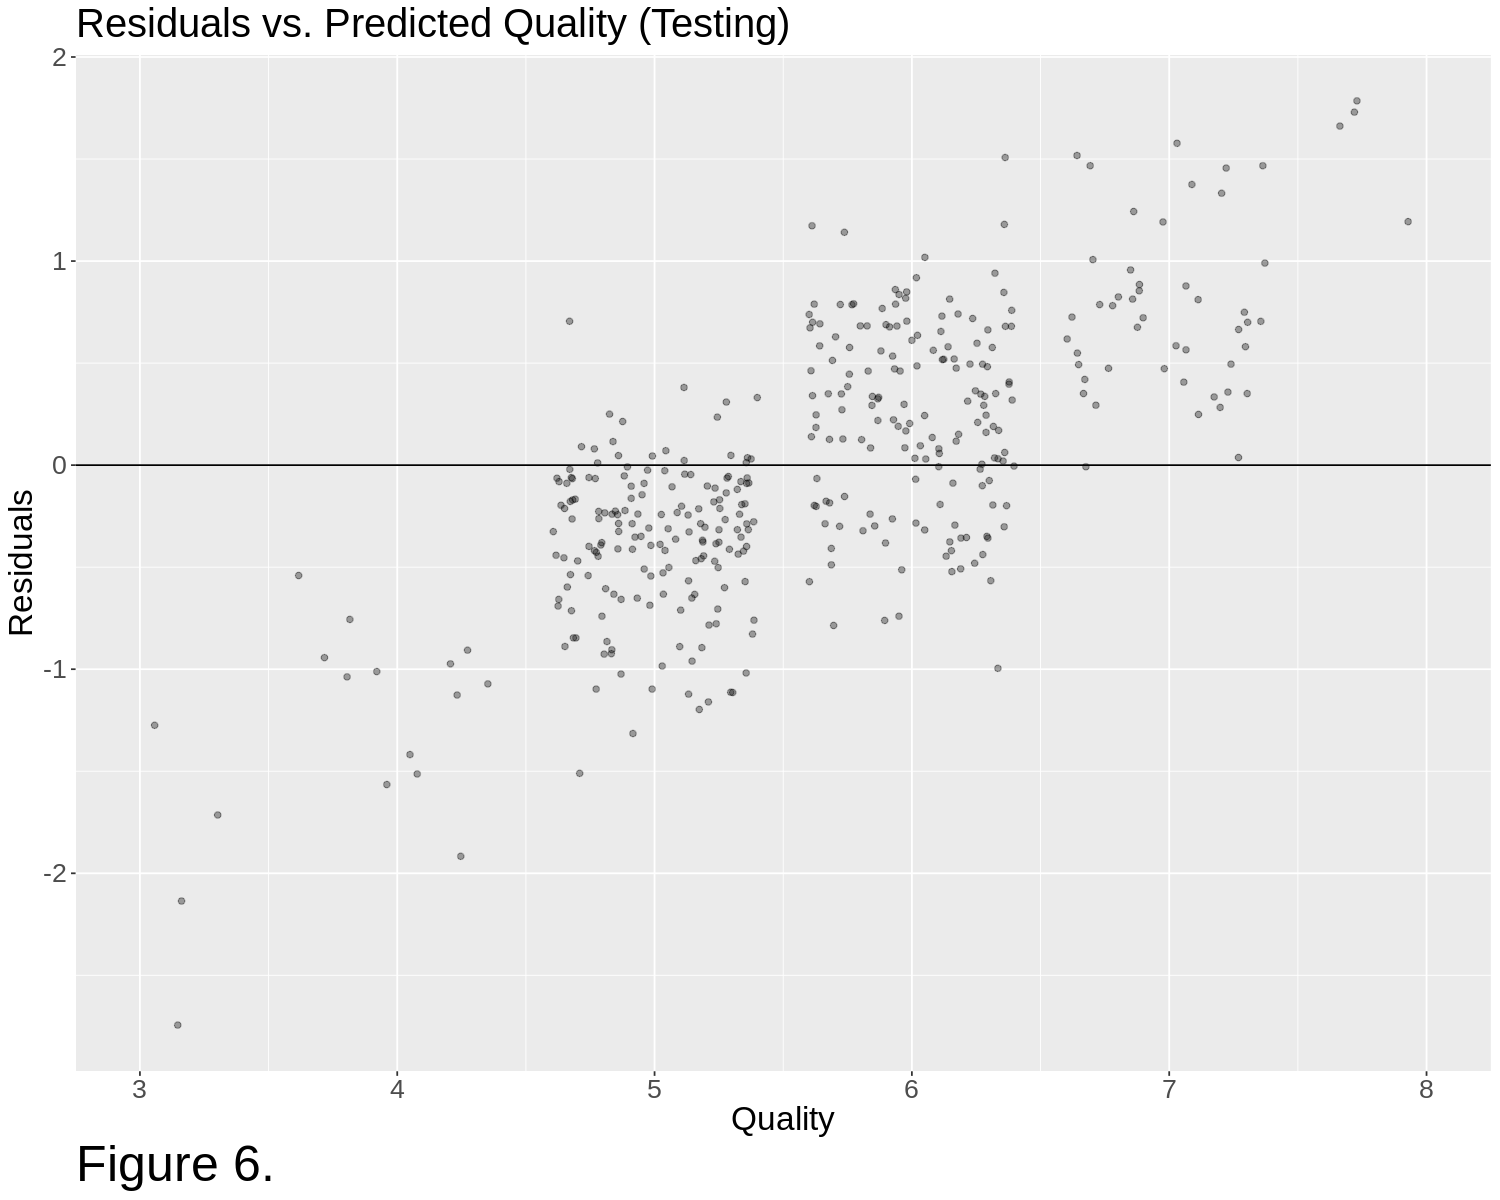

In [16]:

lm_residual_plot_testing 

Figure 6. is a residual plot. The residuals are the difference between the actual and predicted data values. A residual plot allows us to visualize residuals, with the residuals on the vertical axis(y-axis) and the target variable (Quality) on the horizontal axis(x-axis). With the plot we can get a good idea of how well our regression model predicts and what are its biases. Residuals are closest to 0 near the quality of 5 and 6; this shows that our model best predicts quality around 5 and 6. Moreover, it seems than the prediction are biased towards these number, the prediction of wine of higher quality are mostly underestimated, and the wines of a lower quality are overestimated.

**Discussion**

Our correlation plot provided insight into potential predictors' correlation with Wine Quality. Importantly, when generating correlation plots, we are not implying that correlation is causation, but rather that correlation between potential predictors and wine quality act as a rationalization for our model creation. Using our correlation plot (Figure 1), we decided on using: Alcohol, Total Sulfur Dioxide, Volatile Acidity, Citric Acid, Density, and Sulphates as our predictors for our model, given their correlation to Quality. These predictors make sense, given that Wine Quality is often determined by subjective taste, these predictors chosen are known to strongly influence the taste of wine. 

Next, given that Wine Quality can be a number between 0-10, we decided that regression would be the optimal way to predict Wine Quality. However, we had to choose between K-NN Regression and Multiple Linear Regression. 

We created a model using K-NN Regression using K=15, as on our training data K=15 produced the lowest RMSE (Figure 2). We then applied our model to our testing data using K=15, and found an RMSPE of 0.667.

Next, we created a model using Multiple Linear Regression. We found our linear regression equation to be as follows, with an RMSPE of 0.663. Given the scale of our data (0-10), an RMSPE of 0.663 is relatively low and we deem it good for our model. 

We decided that our multiple linear regression model should be used to predict Wine Quality, given that the model had a smaller RMSPE. Interestingly, although the RMSPE for multiple linear regression was smaller, it was still highly similar to the RMSPE for K-NN Regression. It’s possible if our seed was set differently, we may have seen different results as to which model to choose. 

Our model was evaluated using residuals (Figure 5). We found that our model performed best on both training and testing data for wine qualities 5 and 6. As we had an unbalanced dataset with more wine of quality 5 and 6, varied prediction strength expected. 

The impact of our findings from the linear regression model could be significant. The model could be used by wine producers and sellers to make more informed decisions about the quality of their wines, which could help them to better target their products to specific markets or consumers. Furthermore, the model could be used to identify trends and patterns in the data that could be used to improve the production and marketing of wine. This could lead to increased sales and revenue for the wine industry as a whole, as well as for individual producers and sellers. Additionally, the model could be used by consumers to choose wines that are more likely to meet their expectations and preferences, which could lead to increased satisfaction and potentially even repeat purchases. All in all, our model prediction of wine quality has the potential to provide valuable insights and help drive decision-making in the wine industry, which could have positive economic impacts.

In future research, there are several potential questions that could be explored based on our findings. These include: 
1. Can the model be improved by incorporating more data or additional predictors? For example, could the inclusion of weather or soil data improve the accuracy of the model? 
2. How does the model perform on different types of wine, such as white, rose or sparkling? Can the model be adapted to work with different types of wine, or do different models need to be developed for each type? 
3. Can the model be used to predict wine quality for different regions or growing conditions? Can the model be used to identify specific factors that contribute to the quality of wine from a particular region or vineyard?

The future research could focus on exploring the potential applications and addressing the limitations of the model as well as finding ways to improve its accuracy and effectiveness. By addressing these questions, future research could help to expand the capabilities of the model and make it more useful for practical applications in the wine industry.


**Data Sources:**

https://archive.ics.uci.edu/ml/datasets/wine+quality

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

2022 economic impact study of the American wine industry methodology. WineAmerica. (2022, September 21). Retrieved October 28, 2022, from https://wineamerica.org/economic-impact-study/2022-american-wine-industry-methodology/ 

Members archive. Court of Master Sommeliers Europe. (n.d.). Retrieved October 28, 2022, from https://www.courtofmastersommeliers.org/members/ 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5328826/#:~:text=First%2C%20for%20the%20wine%20industry,sluggish%20or%20even%20stuck%20fermentations.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5770432/